In [30]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Data set: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [31]:
# Load the dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
data_raw <- read_csv(url, col_names = names)
data_raw

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [32]:
# Wrangle data
data <- data_raw %>%
    select(c("age", "cp", "trestbps", "thalach", "chol", "num", "fbs")) %>% # select only columns that are used
    mutate(cp = as_factor(cp), # update target variables to factor
          num = as_factor(num),
          fbs = as_factor(fbs)) %>%
    rename(heart_disease = num, # rename some columns with more intuitive names
          rest_bp = trestbps,
          max_heart_rate = thalach)
data

age,cp,rest_bp,max_heart_rate,chol,heart_disease,fbs
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
63,1,145,150,233,0,1
67,4,160,108,286,2,0
67,4,120,129,229,1,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,4,130,115,131,3,0
57,2,130,174,236,1,0
38,3,138,173,175,0,0


In [33]:
# Currently, there are 5 levels of heart disease, 0, 1, 2, 3, 4.
# Classify heart_disease to either 0 (no visible heart disease) or 1-4 (mild heart disease to very severe)
data <- data %>%
    mutate(heart_disease = as_factor(ifelse(heart_disease == 0, "No", "Yes")))
# For cp, we could classify as either 0-1 (no angina) or 2-3 (angina)
data

age,cp,rest_bp,max_heart_rate,chol,heart_disease,fbs
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
63,1,145,150,233,No,1
67,4,160,108,286,Yes,0
67,4,120,129,229,Yes,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,4,130,115,131,Yes,0
57,2,130,174,236,Yes,0
38,3,138,173,175,No,0


In [34]:
# Split the data set into training data and testing data
set.seed(1) # set the seed

heart_split = initial_split(data, prop = 0.75, strata = heart_disease)
heart_training = training(heart_split)
heart_testing = testing(heart_split)

## Preliminary Exploratory Data Analysis

Below are histograms for the four possible predictor variables: age, blood cholesterol, maximum heart rate, and resting blood pressure. Each of the graphs are split up into the groups of people who have heart disease (in blue) and those who don't (in red).

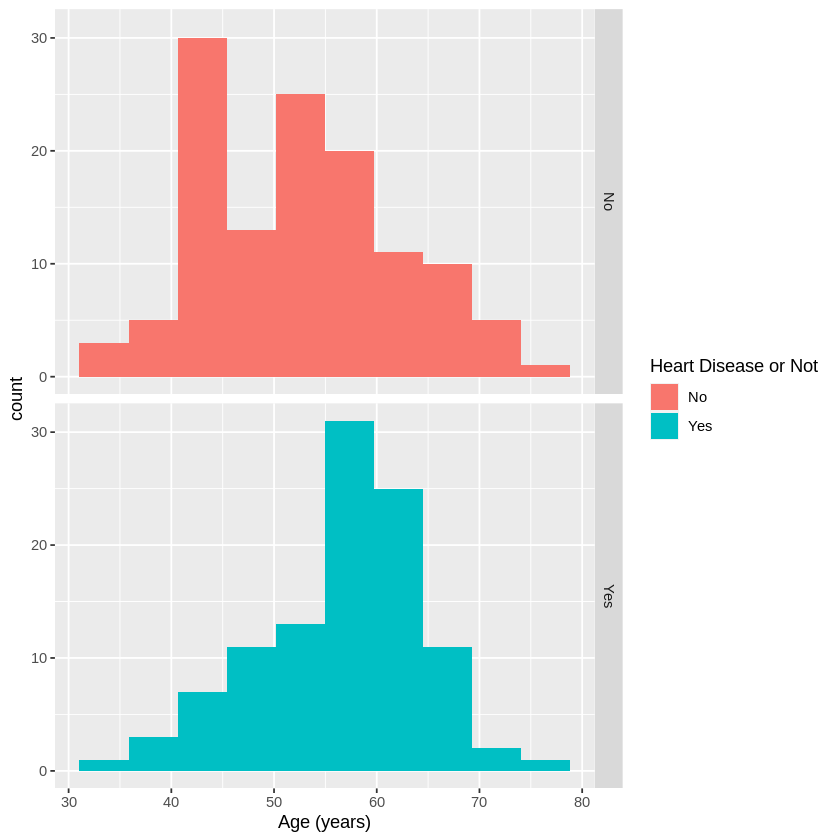

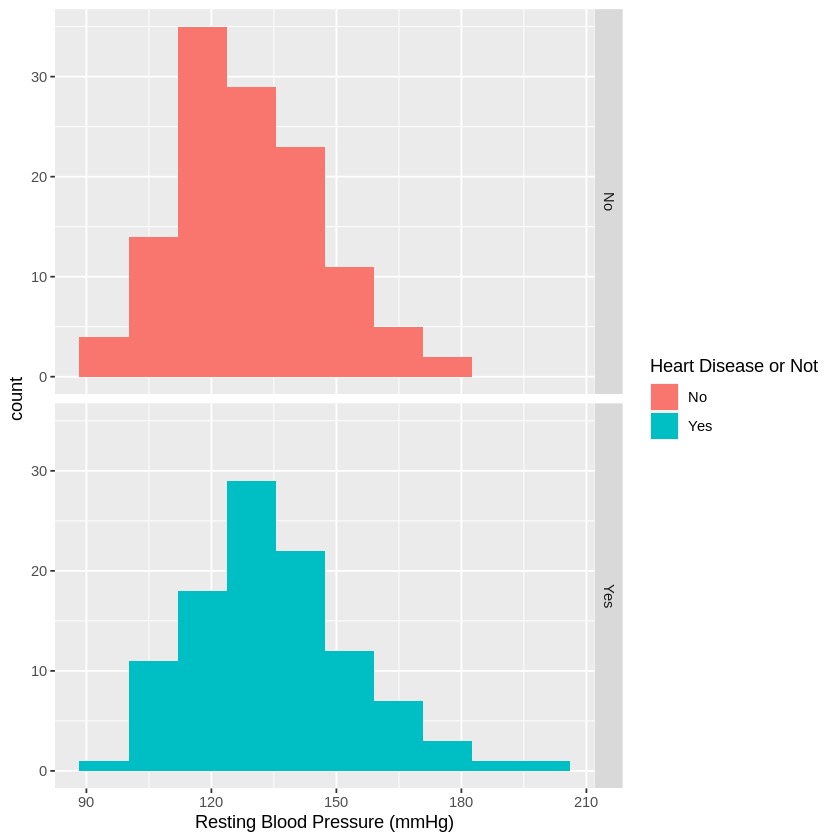

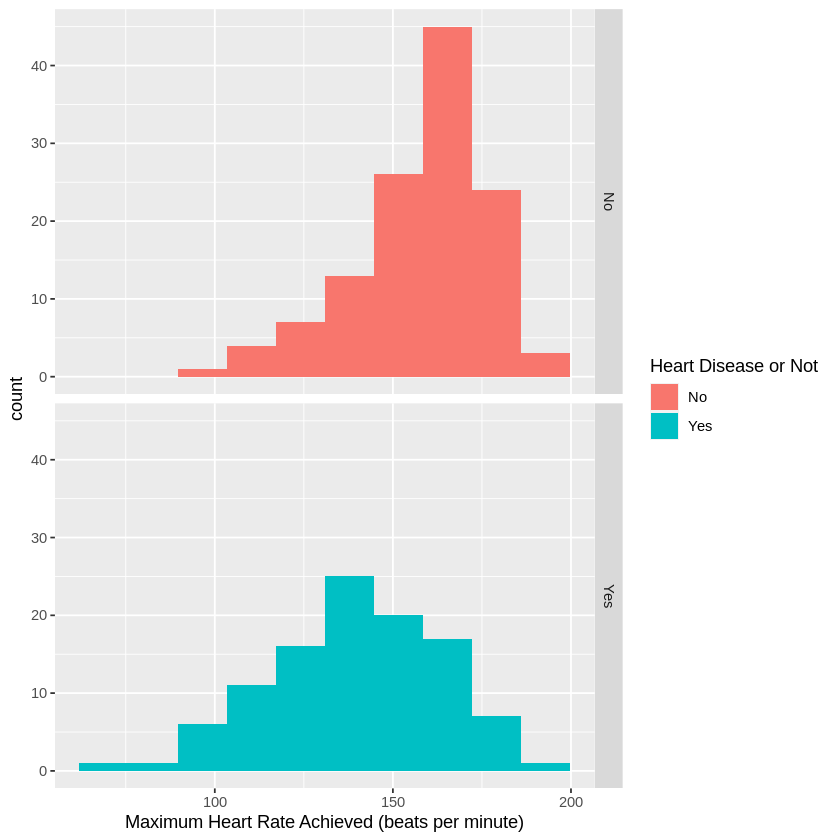

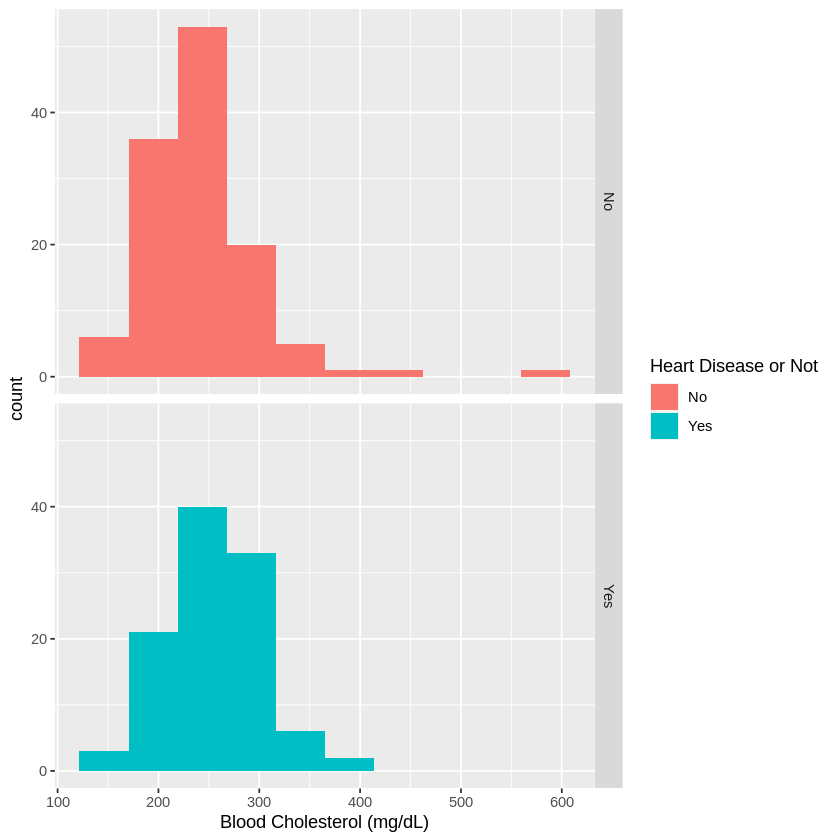

In [35]:
# Histograms for numerical predictor variables
bins_num = ceiling(log(nrow(data),2))+1 # number of bins, by Sturges' formula
# theme_set(theme_grey())
target_var = heart_training$heart_disease # target variable, to split up histograms by (data$num or data$cp)

ggplot(heart_training, aes(x = age, fill = target_var)) +
    geom_histogram(bins = bins_num) +
    facet_grid(rows = target_var) + 
    labs(x = "Age (years)", fill = "Presence of Heart Disease")
ggplot(heart_training, aes(x = rest_bp, fill = target_var)) +
    geom_histogram(bins = bins_num) +
    facet_grid(rows = target_var) + 
    labs(x = "Resting Blood Pressure (mmHg)", fill = "Presence of Heart Disease")
ggplot(heart_training, aes(x = max_heart_rate, fill = target_var)) +
    geom_histogram(bins = bins_num) +
    facet_grid(rows = target_var) + 
    labs(x = "Maximum Heart Rate Achieved (beats per minute)", fill = "Presence of Heart Disease")
ggplot(heart_training, aes(x = chol, fill = target_var)) +
    geom_histogram(bins = bins_num) +
    facet_grid(rows = target_var) + 
    labs(x = "Blood Cholesterol (mg/dL)", fill = "Presence of Heart Disease")

Then, we can roughly compare the distributions to see if any variable individually seems to be associated with the presence of heart disease. From these plots, it seems that age is positively associated with heart disease, and maximum heart rate is negatively associated with heart disease. The other two variables are not clearly associated in either direction.

Below is a bar plot which shows the relative proportion of individuals with and without heart disease in the data set. 

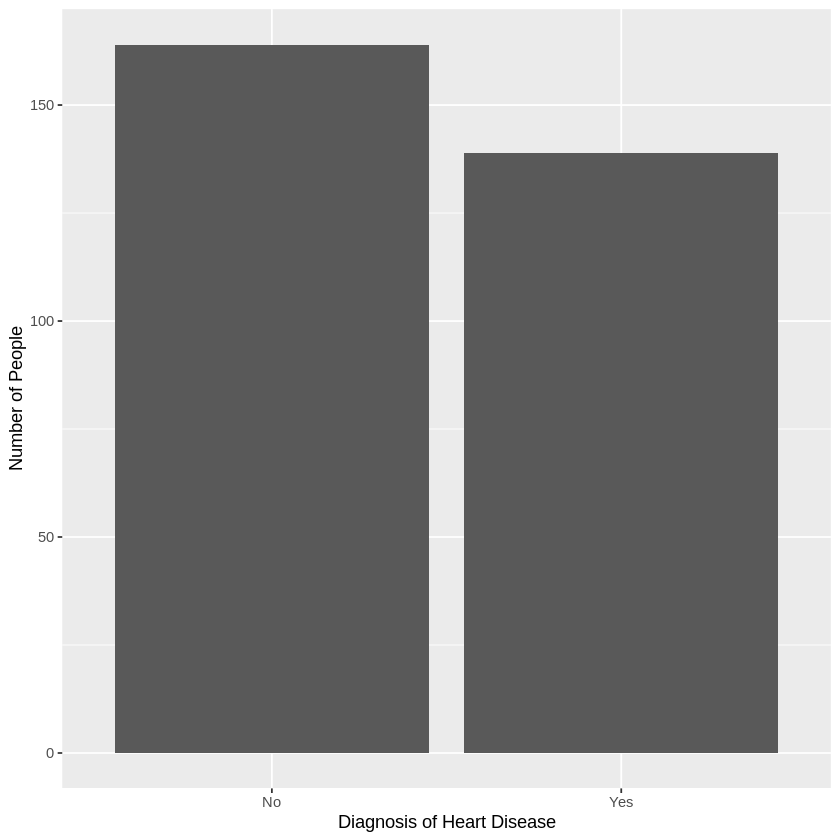

In [38]:
# Bar plots for (potential) target variables
ggplot(data, aes(x = heart_disease)) +
    geom_bar() +
    xlab("Presence of Heart Disease") +
    ylab("Number of People")

Notice that the proportions are roughly equal.

## Methods

In [11]:
# finalize methods

## Expected Outcomes